In [1]:
%autosave 60

Autosaving every 60 seconds


In [2]:
!pip install catboost

In [3]:
import time
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import math
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split

# Итотовая работа по ML
- Подробности на странице на платформе
- Данные для этой работы - это датасет с бинарной целевой переменной. Данные доступны по ссылке на платформе.


Вот описание данных:

**Данные по оттоку клиентов**
- client_id - уникальный id клиента
- регион - локация клиента
- использование - использование мобильной связи
- сумма - сумма пополнения баланса
- частота_пополнения - сколько раз клиент пополнял аккаунт
- доход - доход с одного клиента в месяц
- сегмент_arpu - выручка за квартал
- частота - сколько раз клиент приносил прибыль
- объем_данных - число раз, когда клиент делал подключение
- on_net - число звонков внутри сети
- продукт_1 - тариф 1
- продукт_2 - тариф 2
- зона_1 - звонки из гео-области 1
- зона_2 - звонки из гео-области 2
- mrg_ - флаг
- секретный_скор - некоторый модельный скор клиента
- pack - самый активный пакет клиента
- pack_freq - частота активации пакета pack
- binary_target - флаг оттока клиента

In [4]:
path_data = './'

# не меняйте название переменных train и test - в которых лежат датасеты train.csv и test_full.csv соответсвенно
# эти файлы будут участвовать в тестировании работы

train = pd.read_csv(path_data + 'train.csv')

# test датасет запрещается видоизменять - применять к нему какую либо логику трансформации
# можно видоизменять входные данные внутри функции def get_score(dict_input) (смотри ниже)

test = pd.read_csv(path_data + 'test_full.csv')

## Место для вашего кода ↓↓↓

## Обучение модели / написание вспомогательно кода ↓↓↓

In [5]:
def convert_to_32bit(df):
    df_32 = df.copy()

    for col in df_32.columns:
        col_type = df_32[col].dtype

        if col_type == 'float64':
            df_32[col] = df_32[col].astype('float32')
        elif col_type == 'int64':
            df_32[col] = df_32[col].astype('int32')

    return df_32


def prep(df):
    df = df.copy()

    df = df.drop(
        columns=[
            'client_id', 'продукт_2', 'зона_2', 'pack_freq', 'зона_1', 'pack', 'использование', 'регион', 'mrg_']
    )

    df = convert_to_32bit(df)

    return df

In [6]:
df_train = prep(train)
df_test = prep(test)

In [7]:
X_tr, X_val, y_tr, y_val = train_test_split(
    df_train.drop(columns=["binary_target"]), df_train["binary_target"], test_size=0.2, random_state=42, stratify=train["binary_target"]
)

In [8]:
train_pool = Pool(X_tr, y_tr)
val_pool = Pool(X_val, y_val)

In [9]:
params = {
 'random_state': 42,
 'iterations': 532,
 'loss_function': 'Logloss',
 'verbose': 100,
 'auto_class_weights': 'SqrtBalanced',
 'depth': 5,
 'min_data_in_leaf': 3,
 'learning_rate': 0.10893123623676707,
 }

Обучается около 2 минут

In [10]:
model = CatBoostClassifier(**params)
model.fit(train_pool, eval_set=val_pool)

y_pred = model.predict(val_pool)

0:	learn: 0.6088437	test: 0.6093248	best: 0.6093248 (0)	total: 304ms	remaining: 2m 41s
100:	learn: 0.3647204	test: 0.3658039	best: 0.3658039 (100)	total: 20.7s	remaining: 1m 28s
200:	learn: 0.3635142	test: 0.3652483	best: 0.3652483 (200)	total: 38.6s	remaining: 1m 3s
300:	learn: 0.3627332	test: 0.3651442	best: 0.3651435 (291)	total: 56.4s	remaining: 43.3s
400:	learn: 0.3620723	test: 0.3651074	best: 0.3651007 (391)	total: 1m 17s	remaining: 25.2s
500:	learn: 0.3614352	test: 0.3650755	best: 0.3650752 (494)	total: 1m 35s	remaining: 5.88s
531:	learn: 0.3612641	test: 0.3650753	best: 0.3650697 (510)	total: 1m 41s	remaining: 0us

bestTest = 0.3650697298
bestIteration = 510

Shrink model to first 511 iterations.


Метрика на валидации

In [11]:
f1_score(y_val, y_pred)

0.6511708226842577

## код логики production функции ↓↓↓
У нас маленькая компания, поэтому есть ограничения на вычислительные ресурсы. __Ограничение на число CPU в модели внутри функции def get_score - 1 ядро, это означает что нужно ставить следующие параметры (модель должна работать на одном CPU)__
Если вы обучались на нескольких ядрах CPU (или даже GPU) - поменяйте параметры в уже обученной модели, чтобы в production она использовала только одно ядро

- это нужно явно показать в коде
- для уже обученных моделей:
- для catboost - model.predict(thread_count=1)
- для lightgbm - model.set_params(n_jobs=1) и затем model.get_params().get('n_jobs')
- для xgboost - model.set_params(n_jobs=1) и затем model.get_params()['n_jobs']
- для других классификаторов смотрите документацию



In [12]:
def get_score(dict_input):

    features = np.array([[
        dict_input["сумма"],
        dict_input["частота_пополнения"],
        dict_input["доход"],
        dict_input["сегмент_arpu"],
        dict_input["частота"],
        dict_input["объем_данных"],
        dict_input["on_net"],
        dict_input["продукт_1"],
        dict_input["секретный_скор"],
    ]])

    prob = model.predict_proba(features, thread_count=1)[0, 1]
    binary_prediction = int(prob > 0.5)

    # Не изменять
    return {
        "client_id": dict_input['client_id'],
        "prediction": binary_prediction,
    }

In [13]:
# подсказка

# следите за своей предобработкой
# основное время работы функции должна занимать модель
# можно использовать специальное расширение для понимания - сколько выполняется по времени каждая часть кода
# row_input = ...
# pip install line_profiler
# from line_profiler import profile
# %load_ext line_profiler
# %lprun -f get_score get_score(row_input)

______
## Тут нужно написать код для пятого пункта дз ↓↓↓

*проверка качества предсказания модели (без знания о целевой переменной, только на основе входных данных и выходного предсказания)*

In [14]:
WINDOW = 5_000  # размер окна для агрегации
ALERT_K = 3  # критичность 3sigma от baseline

# средняя доля положительных предсказаний p
# на train/val после обучения модели.
# Используем как норму. Отклонение p от
# baseline - подозрение на drift.
baseline_share = 0.2410

# средняя бинарная энтропия окна при baseline_share
# (-p*log p - (1-p)*log(1-p)).
# Нужна, чтобы контролировать уверенность модели:
# слишком низкая энтропия - переуверенность,
# слишком высокая - модель пугается новых данных.
baseline_entropy = 0.5522

baseline_sigma = 0.0058  # sigma share_pos на train окнах

batch_preds = []
idx_grid = []
share_pos_track = []
entropy_track = []

preds = []

for i, row in enumerate(tqdm(test.itertuples(index=False), total=len(test))):

    dict_input_ = {
        "client_id": row.client_id,
        "регион": row.регион,
        "использование": row.использование,
        "сумма": row.сумма,
        "частота_пополнения": row.частота_пополнения,
        "доход": row.доход,
        "сегмент_arpu": row.сегмент_arpu,
        "частота": row.частота,
        "объем_данных": row.объем_данных,
        "on_net": row.on_net,
        "продукт_1": row.продукт_1,
        "продукт_2": row.продукт_2,
        "зона_1": row.зона_1,
        "зона_2": row.зона_2,
        "mrg_": row.mrg_,
        "секретный_скор": row.секретный_скор,
        "pack": row.pack,
        "pack_freq": row.pack_freq,
    }

    score = get_score(dict_input_)
    pred = score["prediction"]
    preds.append(pred)

    batch_preds.append(pred)

    # фиксируем статистики
    if (i + 1) % WINDOW == 0:
        batch_np = np.array(batch_preds)
        p = batch_np.mean()
        entropy = -(p*math.log(p+1e-8) + (1-p)*math.log(1-p+1e-8))

        idx_grid.append(i + 1)
        share_pos_track.append(p)
        entropy_track.append(entropy)

        if abs(p - baseline_share) > ALERT_K * baseline_sigma:
            print(f"[ALERT] window {i+1-WINDOW}-{i+1}: share_pos {p:.3f} "
                  f"вышла за {ALERT_K}sigma от baseline {baseline_share:.3f}")

        # сбрасываем окно
        batch_preds = []


 65%|██████▌   | 325756/497586 [01:31<00:39, 4296.99it/s]

[ALERT] window 320000-325000: share_pos 0.222 вышла за 3sigma от baseline 0.241


100%|██████████| 497586/497586 [02:16<00:00, 3652.76it/s]


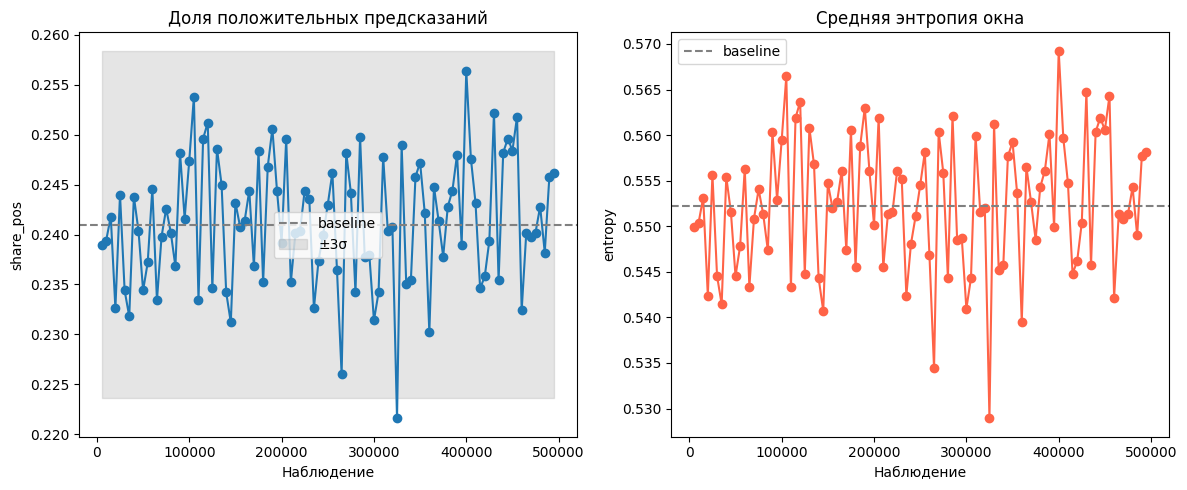

In [15]:
plt.figure(figsize=(12, 5))

# Доля 1
plt.subplot(1, 2, 1)
plt.plot(idx_grid, share_pos_track, marker='o')
plt.axhline(baseline_share, color='gray', linestyle='--', label='baseline')
plt.fill_between(idx_grid,
                 baseline_share - ALERT_K*baseline_sigma,
                 baseline_share + ALERT_K*baseline_sigma,
                 color='gray', alpha=0.2, label=f'±{ALERT_K}σ')
plt.title("Доля положительных предсказаний")
plt.xlabel("Наблюдение")
plt.ylabel("share_pos")
plt.legend()

# Энтропия
plt.subplot(1, 2, 2)
plt.plot(idx_grid, entropy_track, marker='o', color='tomato')
plt.axhline(baseline_entropy, color='gray', linestyle='--', label='baseline')
plt.title("Средняя энтропия окна")
plt.xlabel("Наблюдение")
plt.ylabel("entropy")
plt.legend()

plt.tight_layout()
plt.show()


## Место для вашего кода ↑↑↑
_______

## Автоматические проверки работы ↓↓↓
### Этот код менять нельзя, иначе проверки в ноутбуке могут сломаться

## тест 1: проверка input модели (1)

In [16]:
row_input = {
    'client_id': 1010348,
    'регион': 'Нептун',
    'использование': '>24LY',
    'сумма': 31.69021931132696,
    'частота_пополнения': 16.0,
    'доход': 42653.164535362455,
    'сегмент_arpu': 441.45,
    'частота': 4.242640687119285,
    'объем_данных': 32.01562118716424,
    'on_net': np.nan,
    'продукт_1': 12.0,
    'продукт_2': np.nan,
    'зона_1': np.nan,
    'зона_2': np.nan,
    'mrg_': False,
    'секретный_скор': 0.6065573770491803,
    'pack': 'трафик: 100 (условие) 40mb,_сутки',
    'pack_freq': 3.0,
    'binary_target': 0
}

In [17]:
# если завершилось без ошибок - тест пройден
get_score(row_input)

{'client_id': 1010348, 'prediction': 0}

## тест 2: проверка input модели (2)

In [18]:
row_input = {
    'client_id': -999,
    'регион': 'Калифорния',
    'использование': '<2года',
    'сумма': -999,
    'частота_пополнения': -16.0,
    'доход': -42653.164535362455,
    'сегмент_arpu': -441.45,
    'частота': 0.1,
    'объем_данных': -1,
    'on_net': np.nan,
    'продукт_1': -12.0,
    'продукт_2': np.nan,
    'зона_1': np.nan,
    'зона_2': np.nan,
    'mrg_': True,
    'секретный_скор': -0.6065573770491803,
    'pack': 'трафик Тройное условие 123',
    'pack_freq': -3.0,
    'binary_target': -0.1
}

In [19]:
# если завершилось без ошибок - тест пройден
get_score(row_input)

{'client_id': -999, 'prediction': 1}

## тест 3: проверка output модели

In [20]:
get_score_result = get_score(row_input)

In [21]:
# если завершилось без ошибок - тест пройден
assert get_score_result['prediction'] in [0, 1]

In [22]:
# если завершилось без ошибок - тест пройден
assert not bool(set(get_score_result.keys()) - set(['client_id', 'prediction']))

## тест 4: мониторинг времени (1)
- зеленый цвет названия графика означает - что тест пройден
- красный цвет названия графика означает - что тест не пройден

In [23]:
%%time

# тут ничего менять не нужно
times = []
preds = []

for row in tqdm(test.itertuples(index=False), total=len(test)):

    dict_input_ = {
        "client_id": row.client_id,
        "регион": row.регион,
        "использование": row.использование,
        "сумма": row.сумма,
        "частота_пополнения": row.частота_пополнения,
        "доход": row.доход,
        "сегмент_arpu": row.сегмент_arpu,
        "частота": row.частота,
        "объем_данных": row.объем_данных,
        "on_net": row.on_net,
        "продукт_1": row.продукт_1,
        "продукт_2": row.продукт_2,
        "зона_1": row.зона_1,
        "зона_2": row.зона_2,
        "mrg_": row.mrg_,
        "секретный_скор": row.секретный_скор,
        "pack": row.pack,
        "pack_freq": row.pack_freq,
    }

    # оценка времени работы функции скоринга
    stime = time.time()
    score_result = get_score(dict_input_)
    times.append((time.time() - stime))

    # сохранение предиктов для будущей оценки
    preds.append(score_result['prediction'])

times = np.array(times) * 1000

100%|██████████| 497586/497586 [02:13<00:00, 3730.19it/s]


CPU times: user 2min 9s, sys: 554 ms, total: 2min 9s
Wall time: 2min 13s


#### Отрисовка оценки времени работы

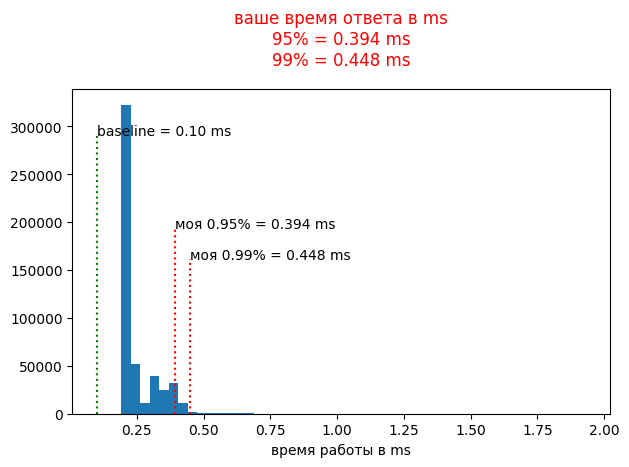

In [24]:
plt_vals = plt.hist(times, bins=np.linspace(np.quantile(times, 0.001), np.quantile(times, 0.999)))

plt.vlines(0.10, 0, plt_vals[0].max() * 0.9, color='green', linestyle=':')
plt.text(0.10, plt_vals[0].max() * 0.9, s='baseline = 0.10 ms', color='black', rotation=0)

plt.vlines(np.quantile(times, 0.95), 0, plt_vals[0].max() * 0.6, color='red', linestyle=':')
plt.vlines(np.quantile(times, 0.99), 0, plt_vals[0].max() * 0.5, color='red', linestyle=':')

plt.text(
    np.quantile(times, 0.95), plt_vals[0].max() * 0.6,
    s=f'моя 0.95% = {np.quantile(times, 0.95):0.3f} ms', color='black', rotation=0
)
plt.text(
    np.quantile(times, 0.99), plt_vals[0].max() * 0.5,
    s=f'моя 0.99% = {np.quantile(times, 0.99):0.3f} ms', color='black', rotation=0
)

plt.title(
    f'ваше время ответа в ms\n95% = {np.quantile(times, 0.95):0.3f} ms\n99% = {np.quantile(times, 0.99):0.3f} ms',
    y=1.05,
    color=(
        'green'
        if (round(np.quantile(times, 0.95), 3) <= 0.10) & (round(np.quantile(times, 0.99), 3) <= 0.10)
        else 'red'
    )
)

plt.xlabel('время работы в ms')
plt.tight_layout()
plt.show()

In [ ]:
# Тут мы должны увидеть, что модель выдает предсказания быстрее ожидаемого
# Наше предсказание должно быть быстрее baseline в каждом случае

## тест 5: мониторинг времени (2)

In [25]:
row_input = {
    'client_id': -100,
    'регион': 'Plan_1',
    'использование': '<000',
    'сумма': 0,
    'частота_пополнения': 0.0,
    'доход': np.nan,
    'сегмент_arpu': np.nan,
    'частота': np.nan,
    'объем_данных': np.nan,
    'on_net': np.nan,
    'продукт_1': np.nan,
    'продукт_2': np.nan,
    'зона_1': np.nan,
    'зона_2': np.nan,
    'mrg_': True,
    'секретный_скор': 0.0,
    'pack': np.nan,
    'pack_freq': np.nan,
}

In [26]:
%%timeit
_ = get_score(row_input)

# Ожидаем скорость быстрее 110 µs (<110 µs)

204 µs ± 7.13 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## тест 6: мониторинг f1 score
- зеленый цвет названия графика означает, что тест пройден
- красный цвет названия графика означает, что тест не пройден

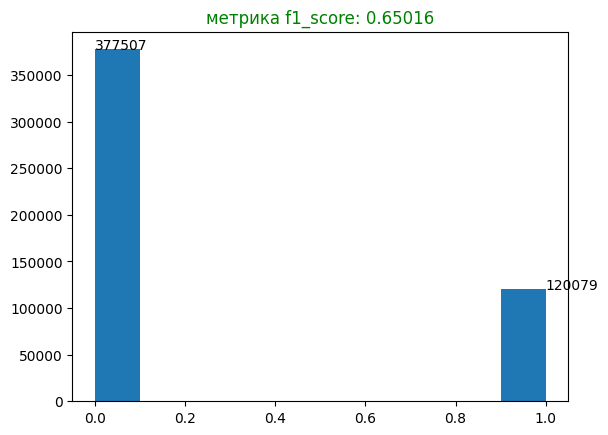

In [27]:
# Ожидаемая метрика >= 0.6450
plot_vals = plt.hist(preds)
plt.title(
    f"метрика f1_score: {f1_score(test['binary_target'], preds):0.5f}",
    color=('red' if f1_score(test['binary_target'], preds) < 0.6450 else 'green')
)

plt.text(0, plot_vals[0][0], s=f"{plot_vals[0][0]:0.0f}")
plt.text(1, plot_vals[0][-1], s=f"{plot_vals[0][-1]:0.0f}")

plt.show()

## тест 7: Code Style
- воспользуемся библиотекой для оценки качества кода https://github.com/nbQA-dev/nbQA?tab=readme-ov-file#-examples
- нужно установить актуальную версию pip install flake8
- нужно установить актуальную версию pip install -U nbqa
- в отдельной ячейке нужно выполнить команду: !nbqa flake8 ML_итоговая_шаблон.ipynb (см. эту команду ниже)
- поставьте вместо ML_итоговая_шаблон.ipynb ваше название ноутбука
- запрещается менять эту команду, за исключением названия ноутбука

In [28]:
!pip install -U nbqa flake8

In [48]:
# os.system("nbqa flake8 --extend-ignore=W291,E501 итоговая.ipynb & echo 'everything done'")

0

In [ ]:
# надо ноутбук положить в директорию (если проверка в гугл коллабе)

In [29]:
!nbqa flake8 --extend-ignore=W291,E501 итоговая.ipynb ; echo "everything done"

everything done


In [ ]:
# ячейка выше должна отпринтовать следующее
# everything done
# 0

# если помимо этого есть и другие строчки - это ошибки по pep8, их нужно исправлять
# например строчка teta_ML_итоговая_шаблон.ipynb:cell_27:1:1: F401 'scipy' imported but unused
# означает, что был бесполезный import scipy, который нигде не использовался

### Если все тесты пройдены успешно, вы можете претендовать на наивысшый балл (⌐■_■)

In [30]:
print('Ура!')

Ура!
